In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Loading and preparing the data 

In [2]:
df = pd.read_csv("stocks_combined_scaled.csv", index_col=0)
#df['daily_volatility'] = df['price'] - df['open']
df.head()

,date,permno,ticker,price,volume,return,high,low,open,avg_price,mkt_cap,pct_return,name_price_attention,volatility,industry
0,2014-01-02,10107,MSFT,-0.999221,1.117934,-0.006683,-0.992613,-1.004799,-0.997672,-0.998750,0.138220,-0.419196,-0.712226,-0.494860,Technology
1,2014-01-03,10107,MSFT,-1.001527,1.148820,-0.006728,-0.994243,-1.009502,-0.999057,-1.001888,0.132557,-0.421781,-0.816796,-0.438358,Technology
2,2014-01-06,10107,MSFT,-1.008721,1.870624,-0.021133,-0.997232,-1.014112,-1.002286,-1.005672,0.114890,-1.249333,-0.771331,-0.410107,Technology
3,2014-01-07,10107,MSFT,-1.006139,1.417816,0.007750,-1.000854,-1.013171,-1.007130,-1.007056,0.121232,0.409965,-0.839528,-0.498392,Technology
4,2014-01-08,10107,MSFT,-1.012134,2.840056,-0.017852,-1.004023,-1.019098,-1.010129,-1.011579,0.106510,-1.060843,-0.807703,-0.448952,Technology


In [3]:
df_test = pd.read_csv("quarterly_financial_data_2013_2023.csv")


#df_test = df_test.rename(columns = {'datedate': 'date'})
df_test['date'] = df_test['datadate']
df_test['ticker'] = df_test['tic']
df_test.head()

,gvkey,datadate,fqtr,tic,conm,net_income,revenue,total_assets,shareholders_equity,total_liabilities,total_debt,sales,operating_activities_cf,capital_expenditures,interest_expense,common_shares_outstanding,earnings_per_share,dividends_per_share,date,ticker
0,1690,2013-03-31,2,AAPL,APPLE INC,9547.0,43603.0,194743.0,135490.0,59253.0,0.0,43603.0,35930.0,4325.0,0.0,940.094,10.16,2.65,2013-03-31,AAPL
1,1690,2013-06-30,3,AAPL,APPLE INC,6900.0,35323.0,199856.0,123354.0,76502.0,16958.0,35323.0,43758.0,6210.0,53.0,908.442,7.51,3.05,2013-06-30,AAPL
2,1690,2013-09-30,4,AAPL,APPLE INC,7512.0,37472.0,207000.0,123549.0,83451.0,16960.0,37472.0,53666.0,8165.0,83.0,899.213,8.31,3.05,2013-09-30,AAPL
3,1690,2013-12-31,1,AAPL,APPLE INC,13072.0,57594.0,225184.0,129684.0,95500.0,16961.0,57594.0,22670.0,1985.0,84.0,892.447,14.59,3.05,2013-12-31,AAPL
4,1690,2014-03-31,2,AAPL,APPLE INC,10223.0,45646.0,205989.0,120179.0,85810.0,16962.0,45646.0,36208.0,3367.0,85.0,861.745,11.69,3.05,2014-03-31,AAPL


In [4]:
anomalies_df = pd.merge(df, df_test[['date','ticker','revenue', 'total_assets', 'earnings_per_share']], on=['date', 'ticker'], how = 'left')
anomalies_df['book_to_market'] = anomalies_df['total_assets'] / anomalies_df['mkt_cap']
anomalies_df['dt_date'] = pd.to_datetime(anomalies_df['date'])
anomalies_df['jan_dummy'] = (anomalies_df['dt_date'].dt.month == 1).astype(int)
anomalies_df['jan_dummy'] = anomalies_df['jan_dummy'].fillna(0)
anomalies_df['monday_dummy'] = (anomalies_df['dt_date'].dt.dayofweek == 0).astype(int)
anomalies_df['monday_dummy'] = anomalies_df['monday_dummy'].fillna(0)
anomalies_df['annual_rep_release'] = anomalies_df['book_to_market'].notna().astype(int)
anomalies_df['annual_rep_release'] = anomalies_df['annual_rep_release'].fillna(0)
#anomalies_df[anomalies_df['book_to_market'].notna()].head()
anomalies_df.head()

,date,permno,ticker,price,volume,return,high,low,open,avg_price,...,volatility,industry,revenue,total_assets,earnings_per_share,book_to_market,dt_date,jan_dummy,monday_dummy,annual_rep_release
0,2014-01-02,10107,MSFT,-0.999221,1.117934,-0.006683,-0.992613,-1.004799,-0.997672,-0.998750,...,-0.494860,Technology,NaN,NaN,NaN,NaN,2014-01-02,1,0,0
1,2014-01-03,10107,MSFT,-1.001527,1.148820,-0.006728,-0.994243,-1.009502,-0.999057,-1.001888,...,-0.438358,Technology,NaN,NaN,NaN,NaN,2014-01-03,1,0,0
2,2014-01-06,10107,MSFT,-1.008721,1.870624,-0.021133,-0.997232,-1.014112,-1.002286,-1.005672,...,-0.410107,Technology,NaN,NaN,NaN,NaN,2014-01-06,1,1,0
3,2014-01-07,10107,MSFT,-1.006139,1.417816,0.007750,-1.000854,-1.013171,-1.007130,-1.007056,...,-0.498392,Technology,NaN,NaN,NaN,NaN,2014-01-07,1,0,0
4,2014-01-08,10107,MSFT,-1.012134,2.840056,-0.017852,-1.004023,-1.019098,-1.010129,-1.011579,...,-0.448952,Technology,NaN,NaN,NaN,NaN,2014-01-08,1,0,0


In [5]:
anomalies_df.to_csv("anomalies_dummies.csv")

### Start with OLS and robust Regression (inspecting the relationships)

In [5]:
# splitting the data 
fix_seed = 42

y = df['return']
X = df[['name_price_attention']]
X2 = df[['name_price_attention', 'mkt_cap']]
X3 = df[['name_price_attention', 'daily_volatility']]
X4 = df[['name_price_attention', 'volume']]
X5 = df[['name_price_attention', 'mkt_cap']]
X6 = df[['name_price_attention', 'mkt_cap']]
X7 = df[['name_price_attention', 'mkt_cap']]
X8 = df[['name_price_attention', 'mkt_cap']]
X9 = df[['name_price_attention', 'mkt_cap']]
X10 = df[['name_price_attention', 'mkt_cap']]
X11 =  df[['name_price_attention', 'mkt_cap']]






X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=fix_seed)

In [6]:
# create OLS regression for y and X
X_train = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     20.30
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           6.63e-06
Time:                        18:03:15   Log-Likelihood:             1.3403e+05
No. Observations:               51206   AIC:                        -2.681e+05
Df Residuals:                   51204   BIC:                        -2.680e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0003 

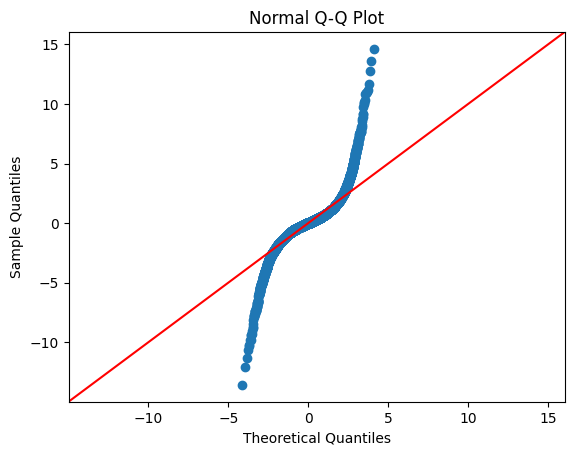

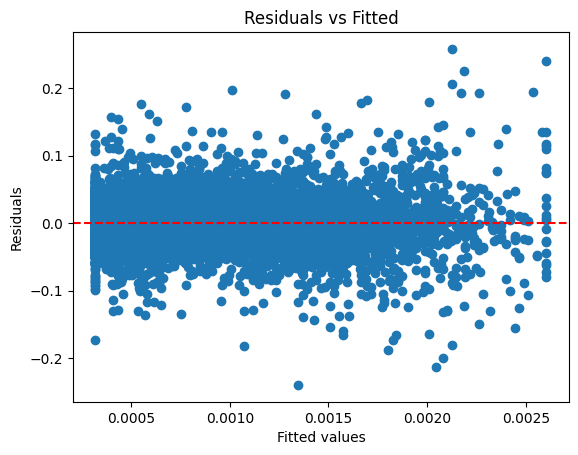

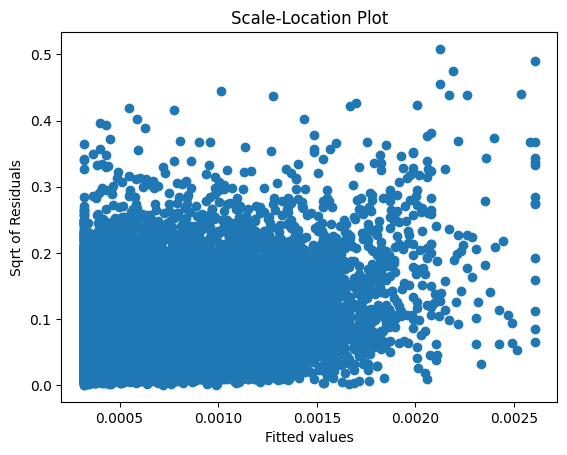

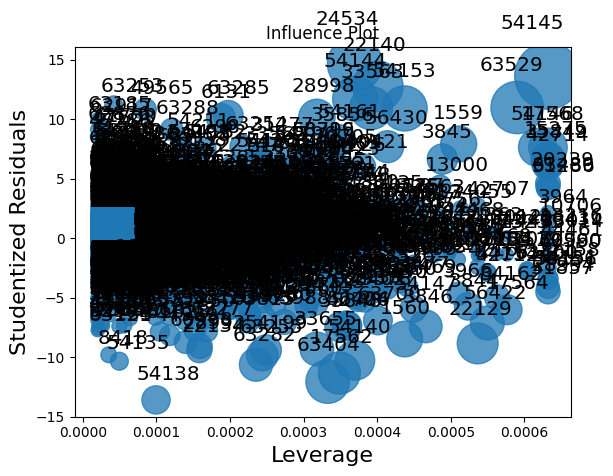

In [7]:
# QQ plot for normality of residuals
fig = sm.qqplot(results.resid, line='45', fit=True)
plt.title('Normal Q-Q Plot')
plt.show()

# Residuals vs Fitted for homoscedasticity
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Scale-Location plot (also called Spread-Location plot)
plt.scatter(results.fittedvalues, results.resid**0.5)
plt.xlabel('Fitted values')
plt.ylabel('Sqrt of Residuals')
plt.title('Scale-Location Plot')
plt.show()

# Leverage plot to find influential cases
sm.graphics.influence_plot(results, criterion="cooks")
plt.title('Influence Plot')
plt.show()

Given these results we will use a robust regression which does not have these assumptions. 

In [8]:
# create numpy arrays for each feature combination to later call in the OLS and robust regression 
X1 = df[['name_price_attention']]
X2 = df[['name_price_attention', 'mkt_cap']]
X3 = df[['name_price_attention', 'daily_volatility']]
X4 = df[['name_price_attention', 'volume']]
X5 = df[['name_price_attention', 'mkt_cap', 'daily_volatility']]
X6 = df[['name_price_attention', 'mkt_cap', 'volume']]
X7 = df[['name_price_attention', 'volume', 'daily_volatility']]
X8 = df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility']]

In [37]:
# create a robust regression for each feature combination
X1= sm.add_constant(X1)
model1 = sm.RLM(y, X1, M=sm.robust.norms.HuberT())
results1 = model1.fit()
print(results1.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64006
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:33                                         
No. Iterations:                    20                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0433 

In [38]:
X = sm.add_constant(X2)
model2 = sm.RLM(y, X, M=sm.robust.norms.HuberT())
results2 = model2.fit()
print(results2.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64005
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:33                                         
No. Iterations:                    19                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0359 

In [39]:
X3 = sm.add_constant(X3)
model3 = sm.RLM(y, X3, M=sm.robust.norms.HuberT())
results3 = model3.fit()
print(results3.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64005
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:34                                         
No. Iterations:                    39                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0394 

In [40]:
X4 = sm.add_constant(X4)
model4 = sm.RLM(y, X4, M=sm.robust.norms.HuberT())
results4 = model4.fit()
print(results4.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64005
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:34                                         
No. Iterations:                    27                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0616 

In [41]:
X5 = sm.add_constant(X5)
model5 = sm.RLM(y, X5, M=sm.robust.norms.HuberT())
results5 = model5.fit()
print(results5.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64004
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:35                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0415 

In [42]:
X6 = sm.add_constant(X6)
model6 = sm.RLM(y, X6, M=sm.robust.norms.HuberT())
results6 = model6.fit()
print(results6.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64004
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:35                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0505 

In [43]:
X7 = sm.add_constant(X7)
model7 = sm.RLM(y, X7, M=sm.robust.norms.HuberT())
results7 = model7.fit()
print(results7.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64004
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:36                                         
No. Iterations:                    46                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0530 

In [44]:
X8 = sm.add_constant(X8)
model8 = sm.RLM(y, X8, M=sm.robust.norms.HuberT())
results8 = model8.fit()
print(results8.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:37                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0493 

In [46]:
from statsmodels.iolib.summary2 import summary_col

# Assuming results1 to results8 are the fitted model results
results_list = [results1, results2, results3, results4, results5, results6, results7, results8]

# Create the regression table
regression_table = summary_col(results_list,
                               stars=True,
                               model_names=[
                                   'Model 1', 'Model 2', 'Model 3',
                                   'Model 4', 'Model 5', 'Model 6',
                                   'Model 7', 'Model 8'
                               ],
                               float_format="%0.2f",
                               info_dict={'N': lambda x: f"{int(x.nobs)}", 'R2': lambda x: f"{x.rsquared:.2f}"})

print(regression_table)

# input layer 784 weil wir 28x28 pixel haben
# man fügt layers hinzu bis der error nicht mehr kleiner wird 
# anschliessend layers kleiner machen bis der error wieder schlechter wird. val_error beobachten, um zu schauen, dass er nicht mehr steigt. 
# schauen ob in der selben epoche der val_error kleiner wird.
# batch size: 
# 
# Goal: best accuracy with lowest computational cost



                     Model 1 Model 2 Model 3 Model 4  Model 5 Model 6  Model 7  Model 8 
----------------------------------------------------------------------------------------
const                0.04*** 0.04*** 0.04*** 0.06***  0.04*** 0.05***  0.05***  0.05*** 
                     (0.01)  (0.01)  (0.00)  (0.01)   (0.00)  (0.01)   (0.00)   (0.00)  
name_price_attention 0.00*** 0.00*** 0.00*** 0.00***  0.00*** 0.00***  0.00***  0.00*** 
                     (0.00)  (0.00)  (0.00)  (0.00)   (0.00)  (0.00)   (0.00)   (0.00)  
mkt_cap                      0.00***                  -0.00   0.00***           0.00*** 
                             (0.00)                   (0.00)  (0.00)            (0.00)  
daily_volatility                     0.43***          0.43***          0.43***  0.43*** 
                                     (0.00)           (0.00)           (0.00)   (0.00)  
volume                                       -0.00***         -0.00*** -0.00*** -0.00***
                    

### Industry 

### including Anomalies 

In [ ]:
X9 = anomalies_df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility', 'jan_dummy']]
X10 = anomalies_df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility', 'monday_dummy']]
X11 = anomalies_df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility', 'annual_rep_release']]
X12 = anomalies_df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility', 'annual_rep_release', 'monday_dummy', 'jan_dummy']]

In [ ]:
X9 = sm.add_constant(X9)
model9 = sm.RLM(y, X9, M=sm.robust.norms.HuberT())
results9 = model9.fit()
print(results9.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64002
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        18:00:12                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X10 = sm.add_constant(X10)
model10 = sm.RLM(y, X10, M=sm.robust.norms.HuberT())
results10 = model10.fit()
print(results10.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64002
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        18:00:20                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X11 = sm.add_constant(X11)
model11 = sm.RLM(y, X11, M=sm.robust.norms.HuberT())
results11 = model11.fit()
print(results11.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64002
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        18:00:30                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X12 = sm.add_constant(X12)
model12 = sm.RLM(y, X12, M=sm.robust.norms.HuberT())
results12 = model12.fit()
print(results12.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64000
Method:                          IRLS   Df Model:                            7
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        18:02:55                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0006 

### Gradient Boost Regressor (ML) 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [ ]:
#splitting the data

fix_seed = 32
#X = df['name_price_attention']  # Extracting the feature
X = anomalies_df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility', 'annual_rep_release', 'monday_dummy', 'jan_dummy']] #subject to change based on Robust regression
y = anomalies_df['pct_return']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=fix_seed)

In [ ]:
params = {
    "n_estimators": 100,
    #"max_depth": 10,
    #"min_samples_split": 5,
    "learning_rate": 0.1,
    #"loss": "squared_error",
} #run a grid search maybe?

gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=fix_seed)
gb_regressor.fit(X_train, y_train)

GradientBoostingRegressor(random_state=32)

In [ ]:
y_pred = gb_regressor.predict(X_test)

# Evaluate the model
mse1 = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse1)

Mean Squared Error: 1.2786028641423457


In [ ]:
feature_importances = gb_regressor.feature_importances_

# Get column names of your features
feature_names = X_train.columns

# Create a dictionary to map feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the dictionary by importance values (optional)
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or access the feature importances
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: daily_volatility, Importance: 0.8621784822251249
Feature: volume, Importance: 0.05406277589976735
Feature: mkt_cap, Importance: 0.04731910959376765
Feature: name_price_attention, Importance: 0.03347539787089543
Feature: monday_dummy, Importance: 0.002869527359730615
Feature: jan_dummy, Importance: 9.470705071399751e-05
Feature: annual_rep_release, Importance: 0.0


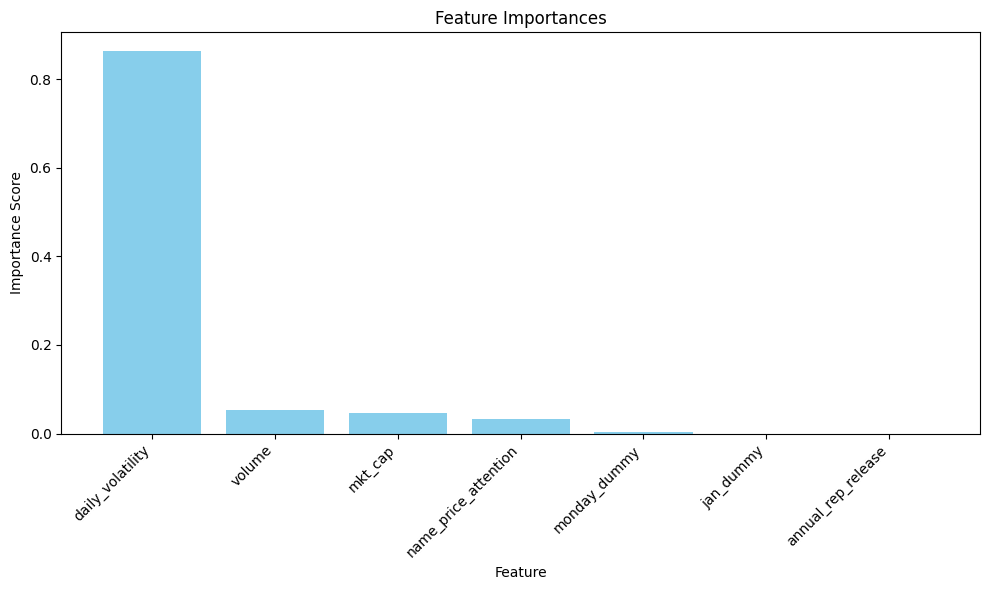

In [ ]:
sorted_features = [x[0] for x in sorted_feature_importance]
sorted_importances = [x[1] for x in sorted_feature_importance]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features)), sorted_importances, color="skyblue", align="center")
plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

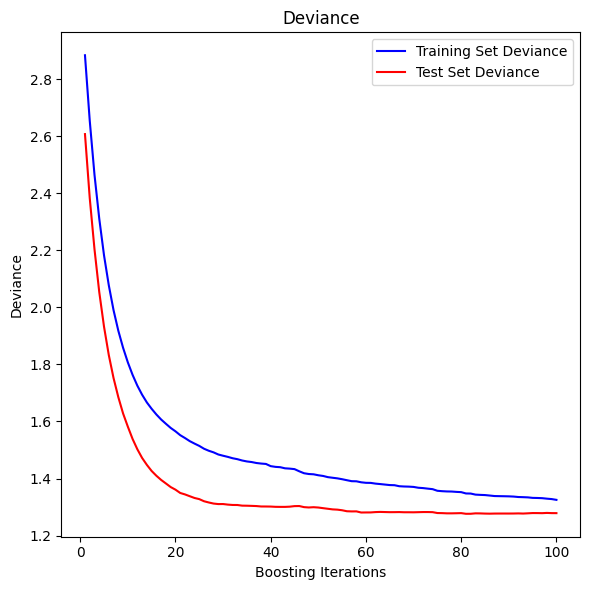

In [ ]:
# Visualization 

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gb_regressor.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gb_regressor.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

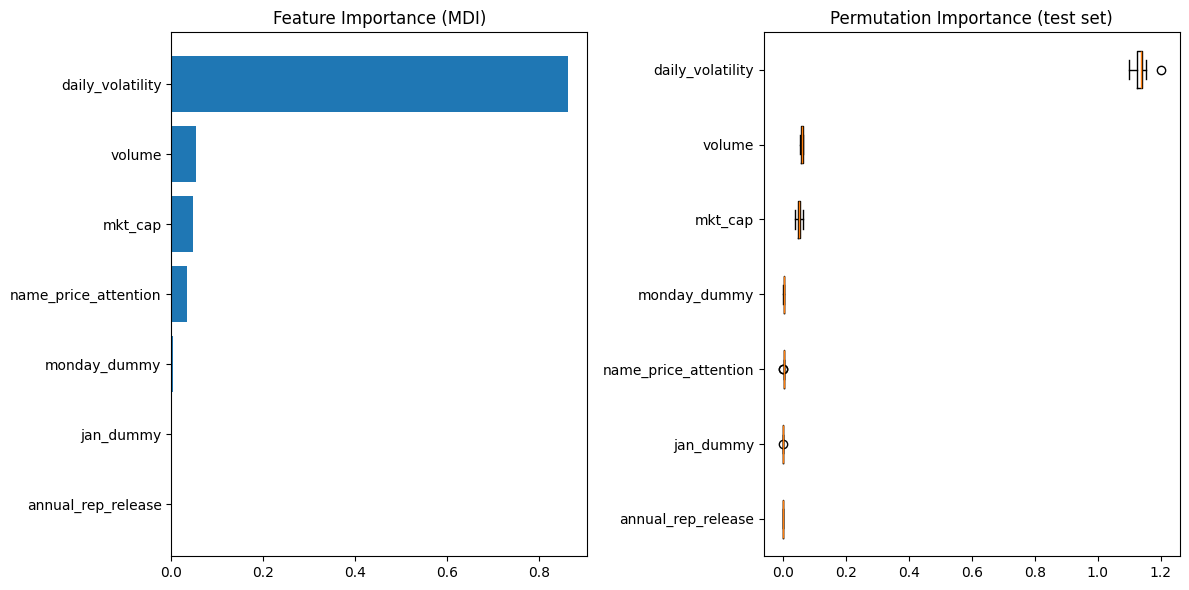

In [ ]:
feature_importance = gb_regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gb_regressor, X_test, y_test, n_repeats=10, random_state=fix_seed, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()